# Initialisation

## Installing necessary components

In [1]:
!pip install transformers
!pip install datasets
!pip install osfclient
# !git clone https://github.com/yjthay/DZ_GenresAndStyle.git
import csv
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import itertools
from sklearn.preprocessing import MultiLabelBinarizer

from datasets import load_dataset, list_datasets
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

!wget https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/utils.py
!wget https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/data/ekman_mapping.json -P ./data/
!wget https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/data/sentiment_mapping.json -P ./data/
# %cd /content/DZ_GenresAndStyle/

     |████████████████████████████████| 2.5MB 9.2MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 
     |████████████████████████████████| 901kB 47.6MB/s 
     |████████████████████████████████| 266kB 9.3MB/s 
     |████████████████████████████████| 122kB 54.0MB/s 
     |████████████████████████████████| 245kB 48.0MB/s 
--2021-07-16 13:42:13--  https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9307 (9.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.09K  --.-KB/s    in 0s      

2021-07-16 13:42:13 (101 MB/s) - ‘utils.py’ saved [9307/9307]

--2021-07-16 13:42:13--  https://raw.githubusercontent.com/yjthay/DZ_GenresAndStyle/master/dat

In [2]:
!osf -p cku2b clone /content/

0files [00:00, ?files/s]
  0% 0.00/209M [00:00<?, ?bytes/s]
  2% 4.21M/209M [00:00<00:15, 13.0Mbytes/s]
  8% 16.8M/209M [00:00<00:12, 15.5Mbytes/s]
 20% 41.7M/209M [00:00<00:07, 21.6Mbytes/s]
 24% 50.3M/209M [00:01<00:06, 24.3Mbytes/s]
 35% 73.5M/209M [00:01<00:04, 33.2Mbytes/s]
 41% 85.3M/209M [00:01<00:03, 38.7Mbytes/s]
 49% 103M/209M [00:01<00:02, 50.6Mbytes/s] 
 56% 117M/209M [00:01<00:01, 61.3Mbytes/s]
 62% 130M/209M [00:01<00:01, 65.5Mbytes/s]
 71% 149M/209M [00:01<00:00, 81.7Mbytes/s]
 78% 162M/209M [00:02<00:00, 84.4Mbytes/s]
 84% 176M/209M [00:02<00:00, 95.8Mbytes/s]
 92% 193M/209M [00:02<00:00, 109Mbytes/s] 
100% 209M/209M [00:02<00:00, 88.0Mbytes/s]
1files [00:12, 12.36s/files]
  0% 0.00/209M [00:00<?, ?bytes/s]
  2% 4.21M/209M [00:00<00:22, 9.05Mbytes/s]
  4% 8.40M/209M [00:00<00:21, 9.42Mbytes/s]
 15% 32.2M/209M [00:00<00:13, 13.2Mbytes/s]
 20% 42.0M/209M [00:01<00:09, 17.2Mbytes/s]
 27% 56.1M/209M [00:01<00:06, 23.4Mbytes/s]
 36% 75.5M/209M [00:01<00:04, 30.7Mbytes/s]
 41

## Utility functions

In [3]:
from utils import *

No config specified, defaulting to: go_emotions/simplified


Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


In [4]:
# Function for training
def train(model, train_dataset, val_dataset, epochs, lr, batch_size, weight_decay, show_progress=False, save_path=None):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Construct data loader from training and validation dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    val_losses = []
    train_losses = []

    num_train = len(train_dataset)

    # Training
    for epoch in range(epochs):
        # backprop
        running_loss = 0.0
        inner_iter = 0
        pbar = tqdm(train_loader, position=0, leave=True)
        epoch_idx = int(epoch+1)
        for x, y in pbar:
            pbar.set_description("Processing Epoch %d" % epoch_idx)

            outputs = model(x)
            optimizer.zero_grad()
            # print(outputs.type(),y.type())
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # calculate training loss
        train_loss = running_loss / len(train_loader)  # calculate validation loss

        with torch.no_grad():
            running_loss = 0.0
            for x_val, y_val in val_loader:
                outputs_val = model(x_val)
                running_loss += criterion(outputs_val, y_val).item()

        # calculate validation loss
        val_loss = running_loss / len(val_loader)  # calculate validation loss

        # print status
        if show_progress:
            print('\n Epoch = %d, Train loss = %.5f, Val loss = %.5f' % (epoch_idx, train_loss, val_loss))

        # append training and validation loss
        val_losses.append(val_loss)
        train_losses.append(train_loss)

        # save model at each epoch
        if save_path is not None:
            save_path_name = save_path + 'epoch_{}_{:.5f}.pt'.format(epoch_idx, val_loss)
            torch.save(model, save_path_name)
        pbar.reset()

    return train_losses, val_losses


def plot_confusion(genre_dict, title, confusion_matrix):
    genres = sorted(genre_dict, key=genre_dict.get)
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(genres)))
    ax.set_yticks(np.arange(len(genres)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(genres)
    ax.set_yticklabels(genres)

    # Loop over data dimensions and create text annotations.
    for i in range(len(genres)):
        for j in range(len(genres)):
            text = ax.text(j, i, '%.2f' % confusion_matrix[i, j], ha="center", va="center", color="tab:red", size=15)

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.tight_layout()
    plt.show()

## Load full dataset

In [5]:
data = load_dataset('go_emotions')

No config specified, defaulting to: go_emotions/simplified
Reusing dataset go_emotions (/root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


## Analysis of labels

Total number of train, test and validation samples is 54263
Number of samples with 1 label/labels = 45446
Number of samples with 2 label/labels = 8124
Number of samples with 3 label/labels = 655
Number of samples with 4 label/labels = 37
Number of samples with 5 label/labels = 1


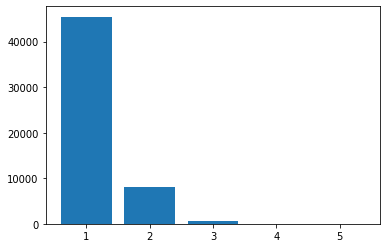

In [6]:
data_labels_all = data['train']['labels'] + data['test']['labels'] + data['validation']['labels']
print("Total number of train, test and validation samples is {}".format(len(data_labels_all)))
_labels, _counts = np.unique([len(y) for y in data_labels_all], return_counts=True)
plt.bar(_labels, _counts, align='center')
plt.gca().set_xticks(_labels)
[print("Number of samples with {} label/labels = {}".format(i, j)) for i, j in zip(_labels, _counts)]
plt.show()

In [7]:
label_mapping = {}
label_names = data['train'].features['labels'].__dict__['feature'].names
for i, emotion in enumerate(label_names):
    label_mapping[i] = emotion.strip()
label_mapping

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

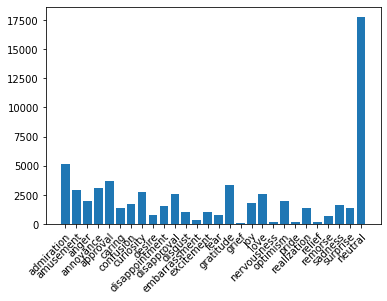

In [8]:
all_labels = list(itertools.chain.from_iterable(data_labels_all))
_labels, _counts = np.unique(all_labels, return_counts=True)
fig, ax = plt.subplots()
fig = plt.bar(_labels, _counts, align='center')
plt.gca().set_xticks(_labels)
ax.set_xticklabels(label_names, horizontalalignment='right', wrap=True, rotation=45)
plt.show()

## Analysis of text

In [9]:
data_text_all = data['train']['text'] + data['test']['text'] + data['validation']['text']
BERT_TYPE_LIST = ['bert-base-cased', 'roberta-base']
bert_type = 'bert-base-cased'
[print(i) for i in data_text_all[:5]]
tokenizer = BertTokenizer.from_pretrained(bert_type)
tokens = tokenizer(data_text_all, padding='max_length', truncation=True, max_length=60, return_tensors="pt")
# tokens = tokenizer(data_text_all, padding=True, return_tensors="pt")

My favourite food is anything I didn't have to cook myself.
Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
WHY THE FUCK IS BAYLESS ISOING
To make her feel threatened
Dirty Southern Wankers


(array([ 5695., 11332., 12211.,  9291.,  8948.,  5198.,  1143.,   317.,
           77.,    51.]),
 array([ 3. ,  8.7, 14.4, 20.1, 25.8, 31.5, 37.2, 42.9, 48.6, 54.3, 60. ]),
 <a list of 10 Patch objects>)

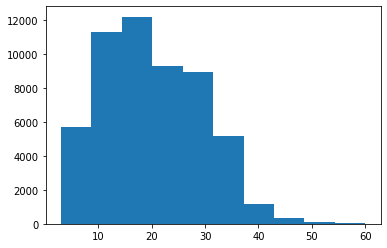

In [10]:
from scipy import stats

max_len = 0
total = 0
a = [sum(i != 0).item() for i in tokens['input_ids']]
plt.hist(a)

In [11]:
for input, att in zip(tokens['input_ids'], tokens['attention_mask']):
    if sum(att) >= 60:
        print(sum(att))
        print(tokenizer.decode(input))

tensor(60)
[CLS] If you ’ re concerned about [ NAME ], then you must still be concerned about [ NAME ]. WAR over last 2 seasons : [ NAME ] : 4. 8, 3. 1 [ NAME ] : 4. 0, 3. 6 [SEP]
tensor(60)
[CLS] YO HERE'S DYNASTY WITH ANOTHER EX CLU SIVE LOOK AT THE ALL NEW MORTAL KOMBAAAAAT COVER ART ( 5 Minutes later )... [SEP]
tensor(60)
[CLS] I THOUGHT IT WAS JUST ONE GUY AND I WAS SERIOUSLY HERE TO POST ABOUT YOUTUBE'S COMMENT ALGORITHM BUT * * OH Y [SEP]
tensor(60)
[CLS] good start [ NAME ]. MORE! MORE TRADES! GET WHAT YOU CAN! SELL, SELL, SELL! # BurnItDown # NobodyIsSafe # ShapeUpO [SEP]
tensor(60)
[CLS] ackchyually, it's * r / woooosh ^ ^ ^ ^ ^ I'm ^ ^ ^ ^ ^ a ^ ^ ^ ^ ^ bot. ^ ^ ^ ^ ^ Complaints ^ ^ ^ ^ ^ should ^ ^ ^ ^ ^ be [SEP]
tensor(60)
[CLS] me : haha im an incel. rApE sHoUlD bE lEgAl! wOmEn ArE iNcApAbLe Of ThInKiNg greaseball who stares [SEP]
tensor(60)
[CLS] NO absolueltey wrong. WE MUST PRIORITIZE GETTING CORPORATE MONEY OUT OF POLITICS OR WE WILL NEVER BE ABLE TO SOLVE AN [SEP]
te

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(perplexity=30,
                  n_components=2,
                  n_iter=1000,
                  random_state=23,
                  learning_rate=500,
                  init="pca")
test = data['test']

data_test = EmotionsDataset(test)
test_text, test_label = [],[]
for x, y in data_test:
    test_text.append(x.tolist())
    test_label.append(y.tolist())
new_values = tsne_model.fit_transform(test_text[:,:-1])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<module 'matplotlib.pyplot' from 'C:\\Users\\thayy\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

TypeError: must be real number, not str

<Figure size 720x720 with 1 Axes>

In [ ]:
visualize_scatter(new_values, test_label[:,:-1], label_mapping)

# Training

In [ ]:
# Genre-label conversion dictionary
DEVICE = 'cuda'  # cuda or cpu
model, tokenizer = BertModel, BertTokenizer
max_length = 64
BERT_TYPE = 'bert-base-cased'
pre_path='/content/drive/MyDrive/DeepZen/'
pre_path=''

model_save_path = pre_path+'model/'

train_dataset = EmotionsDataset(data['train'], device=DEVICE, Model=model, Tokenizer=tokenizer, bert_type=BERT_TYPE, max_length=max_length)
val_dataset = EmotionsDataset(data['validation'], device=DEVICE, Model=model, Tokenizer=tokenizer, bert_type=BERT_TYPE, max_length=max_length)
model_save_path = pre_path+'model/'
pickle_dump(train_dataset, model_save_path + str(max_length) + '_train_EmotionsDataset.pkl')
pickle_dump(val_dataset, model_save_path + str(max_length) + '_val_EmotionsDataset.pkl')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predic

## Training model for various BERTs

In [ ]:
# BERT_TYPE_LIST = ['bert-base-cased','bert-base-uncased','distilbert-base-cased', 'roberta-large','roberta-base','distilroberta-base']
DEVICE = 'cuda'  # cuda or cpu
model_save_path = pre_path+'model/'
save_path = pre_path+'model/epochs/'+str(max_length)+'/'
# DEVICE = torch.device('cuda:0')

print(BERT_TYPE)
train_dataset = pickle_load(model_save_path + str(max_length) + '_train_EmotionsDataset.pkl')
val_dataset = pickle_load(model_save_path + str(max_length) + '_val_EmotionsDataset.pkl')
model = Layers((max_length * 768, 256, 28)).to(DEVICE) #(input dim, hidden dim, output dim)
train_losses, val_losses = train(model, train_dataset, val_dataset, epochs=20, lr=2e-5, batch_size=16,
                                 weight_decay=0.001, show_progress=True, save_path=save_path)

bert-base-cased


Processing Epoch 1: 100%|██████████| 2714/2714 [40:54<00:00,  1.11it/s] 



 Epoch = 1, Train loss = 0.12561, Val loss = 0.11265


FileNotFoundError: [Errno 2] No such file or directory: '/model/epochs/64/epoch_1_0.11265.pt'

# Analysis of results

Loading the best model based on the validation error

In [12]:
DEVICE = 'cuda' #'cpu'
pre_path = 'osfstorage/'
model_file_path = best_model_filename(pre_path+'model/epochs/64/')
model = torch.load(model_file_path, map_location=torch.device(DEVICE))
label_mapping = mapping()
print(model_file_path)

osfstorage/model/epochs/64/epoch_18_0.10616.pt


## F1 Score of Testing Set

In [13]:
test_data = EmotionsDataset(data['test'], max_length=64, device=DEVICE)
y_pred_test = predict(model, test_data)
y_true_test =  test_data.labels.cpu().numpy()

for i in range(1,10):
    threshold = i/10.
    y_pred = (y_pred_test>=threshold) * np.ones(y_pred_test.shape)
    f1 = f1_score(y_true_test, y_pred, average='samples')
    print("Testing - Sigmoid Threshold of {} yields an f1 score of {}".format(threshold, f1))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Testing - Sigmoid Threshold of 0.1 yields an f1 score of 0.46732957786025775
Testing - Sigmoid Threshold of 0.2 yields an f1 score of 0.46766256898926883
Testing - Sigmoid Threshold of 0.3 yields an f1 score of 0.4091526494511569
Testing - Sigmoid Threshold of 0.4 yields an f1 score of 0.3431914501566243
Testing - Sigmoid Threshold of 0.5 yields an f1 score of 0.26365702352435355
Testing - Sigmoid Threshold of 0.6 yields an f1 score of 0.1832811252380075
Testing - Sigmoid Threshold of 0.7 yields an f1 score of 0.11104968982249247
Testing - Sigmoid Threshold of 0.8 yields an f1 score of 0.06354032307597814
Testing - Sigmoid Threshold of 0.9 yields an f1 score of 0.03519439837847798


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

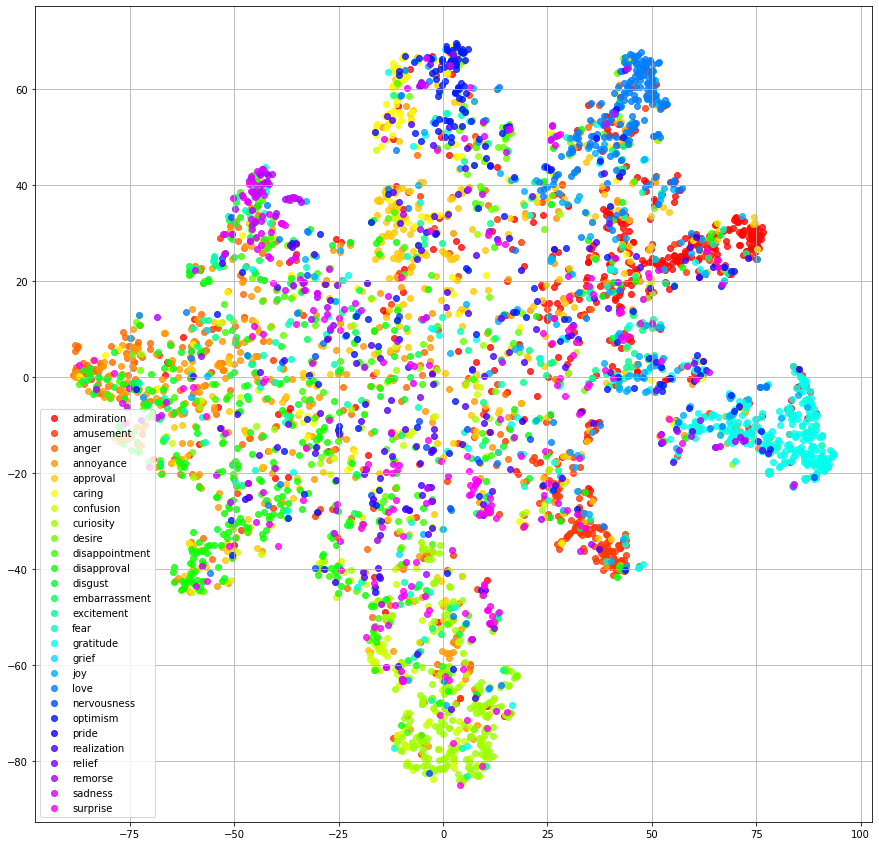

In [14]:
# Ignoring neutral
visualize_scatter(gen_tsne_values(y_pred_test[:,:-1]), y_true_test[:,:-1], label_mapping, figsize=(15,15))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

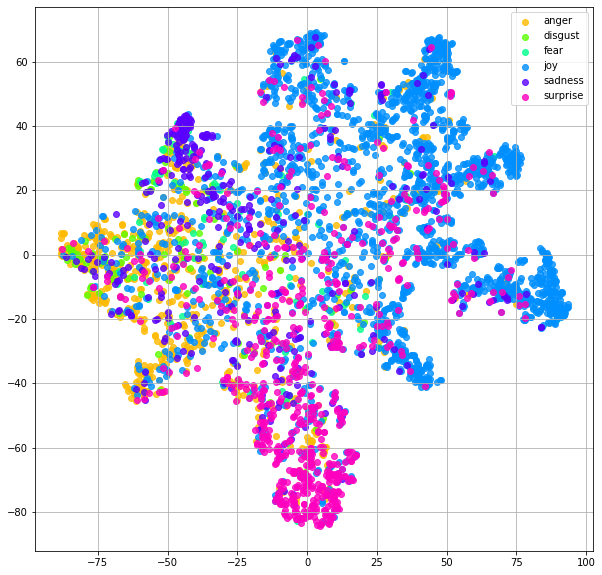

In [15]:
y_true_test_ekman = convert_to_ekman(reverse_one_hot(y_true_test))
y_true_test_ekman = label_multi_one_hot(y_true_test_ekman).numpy()
ekman_fname='data/ekman_mapping.json'
with open(ekman_fname) as f:
    ekman_mapping = json.load(f)
ekman_label_mapping = {}
for idx, key in enumerate(ekman_mapping):
    ekman_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_test[:,:-1]), y_true_test_ekman[:,:-1], ekman_label_mapping)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

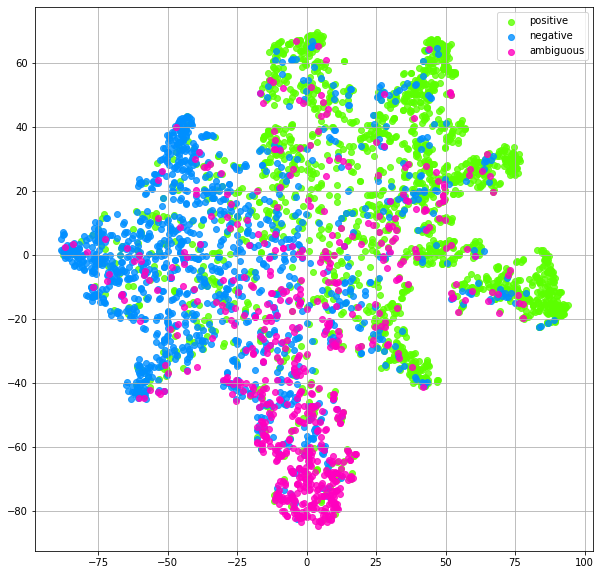

In [31]:
#%%
y_true_test_sentiment = convert_to_sentiment(reverse_one_hot(y_true_test))
y_true_test_sentiment = label_multi_one_hot(y_true_test_sentiment).numpy()
sentiment_fname='data/sentiment_mapping.json'
with open(sentiment_fname) as f:
    sentiment_mapping = json.load(f)
sentiment_label_mapping = {}
for idx, key in enumerate(sentiment_mapping):
    sentiment_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_test[:,:-1]), y_true_test_sentiment[:,:-1], sentiment_label_mapping)

## F1 Score of Validation Set

In [16]:
val_data = EmotionsDataset(data['validation'], max_length=64, device=DEVICE)
y_pred_val = predict(model, val_data)
y_true_val =  val_data.labels.cpu().numpy()

for i in range(1,10):
    threshold = i/10.
    y_pred = (y_pred_val>=threshold) * np.ones(y_pred_val.shape)
    f1 = f1_score(y_true_val, y_pred, average='samples')
    print("Validation - Sigmoid Threshold of {} yields an f1 score of {}".format(threshold, f1))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Validation - Sigmoid Threshold of 0.1 yields an f1 score of 0.4717714238908489
Validation - Sigmoid Threshold of 0.2 yields an f1 score of 0.47293367033507094
Validation - Sigmoid Threshold of 0.3 yields an f1 score of 0.4150509890649957
Validation - Sigmoid Threshold of 0.4 yields an f1 score of 0.33832780439857474
Validation - Sigmoid Threshold of 0.5 yields an f1 score of 0.26705369209976654
Validation - Sigmoid Threshold of 0.6 yields an f1 score of 0.18719744440348934
Validation - Sigmoid Threshold of 0.7 yields an f1 score of 0.10782651431379775
Validation - Sigmoid Threshold of 0.8 yields an f1 score of 0.05920260474259737
Validation - Sigmoid Threshold of 0.9 yields an f1 score of 0.033370192898390466


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

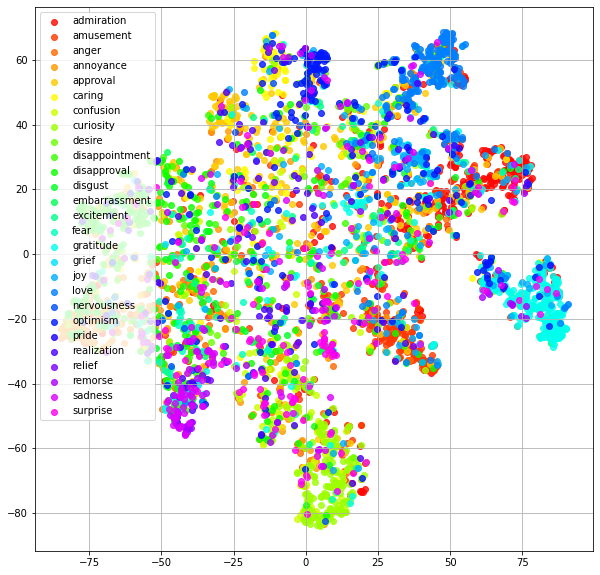

In [17]:
# Ignoring neutral
visualize_scatter(gen_tsne_values(y_pred_val[:,:-1]), y_true_val[:,:-1], label_mapping)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

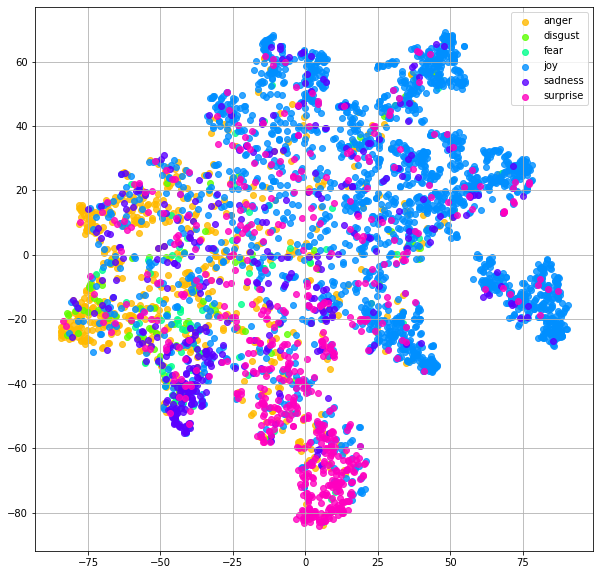

In [18]:
#%%
y_true_val_ekman = convert_to_ekman(reverse_one_hot(y_true_val))
y_true_val_ekman = label_multi_one_hot(y_true_val_ekman).numpy()
ekman_fname='data/ekman_mapping.json'
with open(ekman_fname) as f:
    ekman_mapping = json.load(f)
ekman_label_mapping = {}
for idx, key in enumerate(ekman_mapping):
    ekman_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_val[:,:-1]), y_true_val_ekman[:,:-1], ekman_label_mapping)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

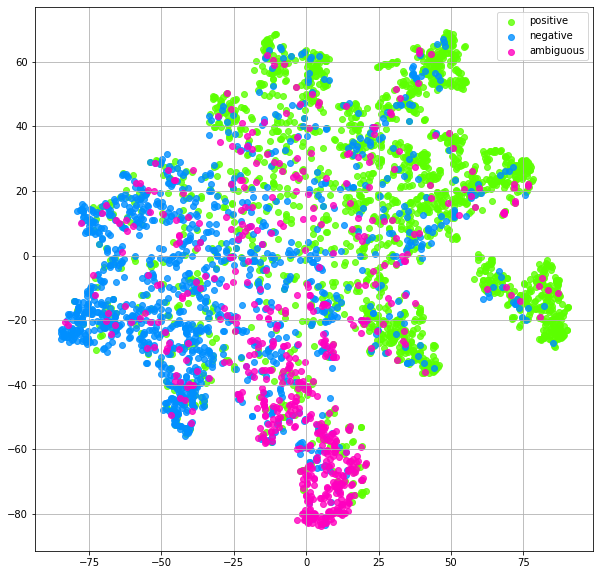

In [30]:
#%%
y_true_val_sentiment = convert_to_sentiment(reverse_one_hot(y_true_val))
y_true_val_sentiment = label_multi_one_hot(y_true_val_sentiment).numpy()
sentiment_fname='data/sentiment_mapping.json'
with open(sentiment_fname) as f:
    sentiment_mapping = json.load(f)
sentiment_label_mapping = {}
for idx, key in enumerate(sentiment_mapping):
    sentiment_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_val[:,:-1]), y_true_val_sentiment[:,:-1], sentiment_label_mapping)

## F1 Score of Training Set

In [19]:
train_data = EmotionsDataset(data['train'], max_length=64, device=DEVICE)
y_pred_train = predict(model, train_data)
y_true_train =  train_data.labels.cpu().numpy()

for i in range(1,10):
    threshold = i/10.
    y_pred = (y_pred_train>=threshold) * np.ones(y_pred_train.shape)
    f1 = f1_score(y_true_train, y_pred, average='samples')
    print("Training - Sigmoid Threshold of {} yields an f1 score of {}".format(threshold, f1))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training - Sigmoid Threshold of 0.1 yields an f1 score of 0.5215025331473154
Training - Sigmoid Threshold of 0.2 yields an f1 score of 0.5326686119429728
Training - Sigmoid Threshold of 0.3 yields an f1 score of 0.47279768760763924
Training - Sigmoid Threshold of 0.4 yields an f1 score of 0.3944152652998541
Training - Sigmoid Threshold of 0.5 yields an f1 score of 0.3062274437533595
Training - Sigmoid Threshold of 0.6 yields an f1 score of 0.21529985410427704
Training - Sigmoid Threshold of 0.7 yields an f1 score of 0.12823082239115413
Training - Sigmoid Threshold of 0.8 yields an f1 score of 0.06642248329877908
Training - Sigmoid Threshold of 0.9 yields an f1 score of 0.03508408200875374


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

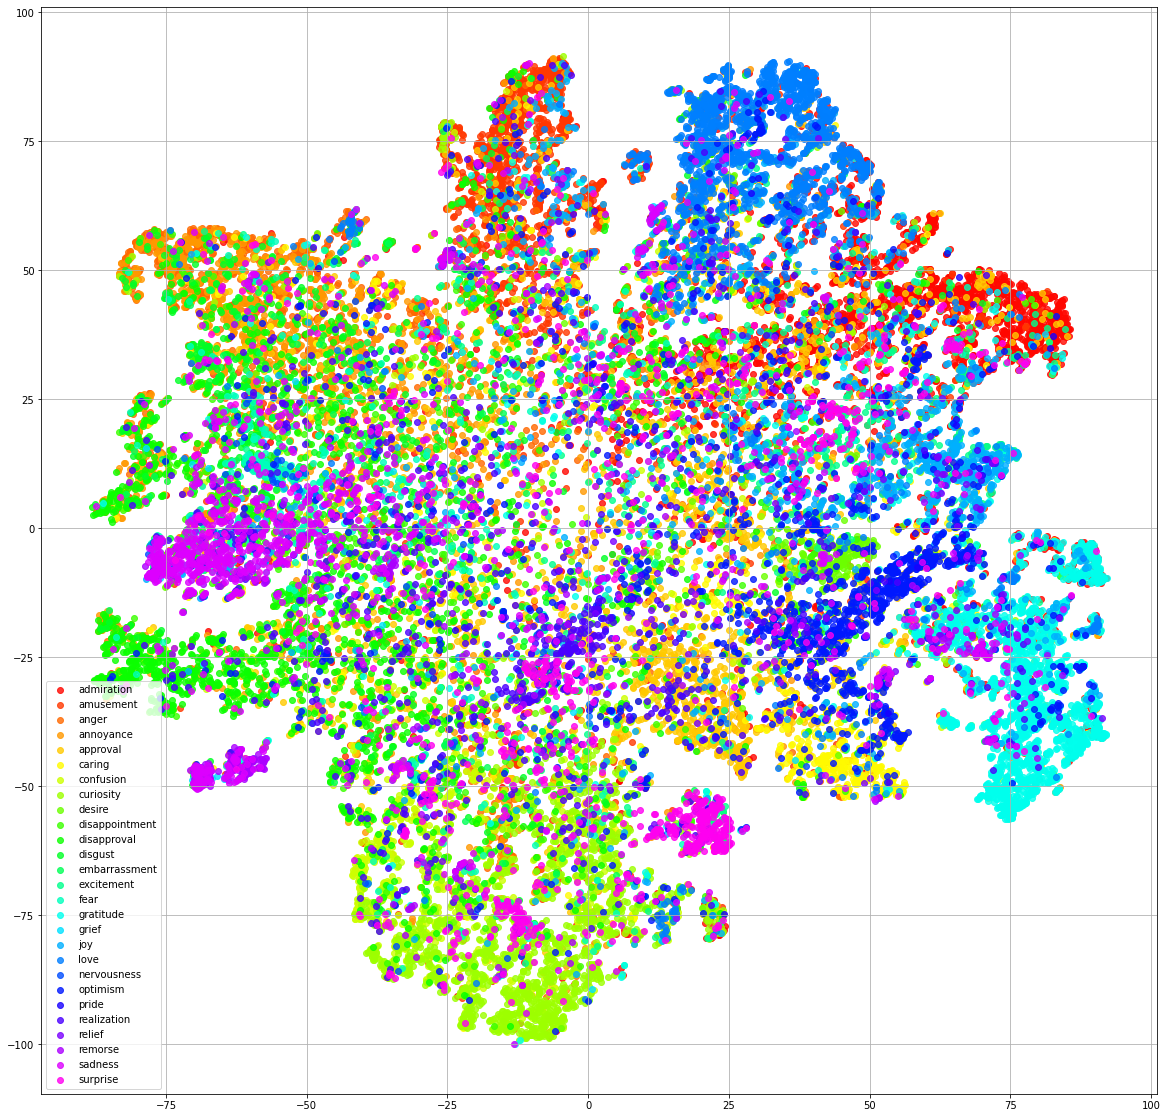

In [23]:
# Ignoring neutral
visualize_scatter(gen_tsne_values(y_pred_train[:,:-1]), y_true_train[:,:-1], label_mapping, figsize=(20,20))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

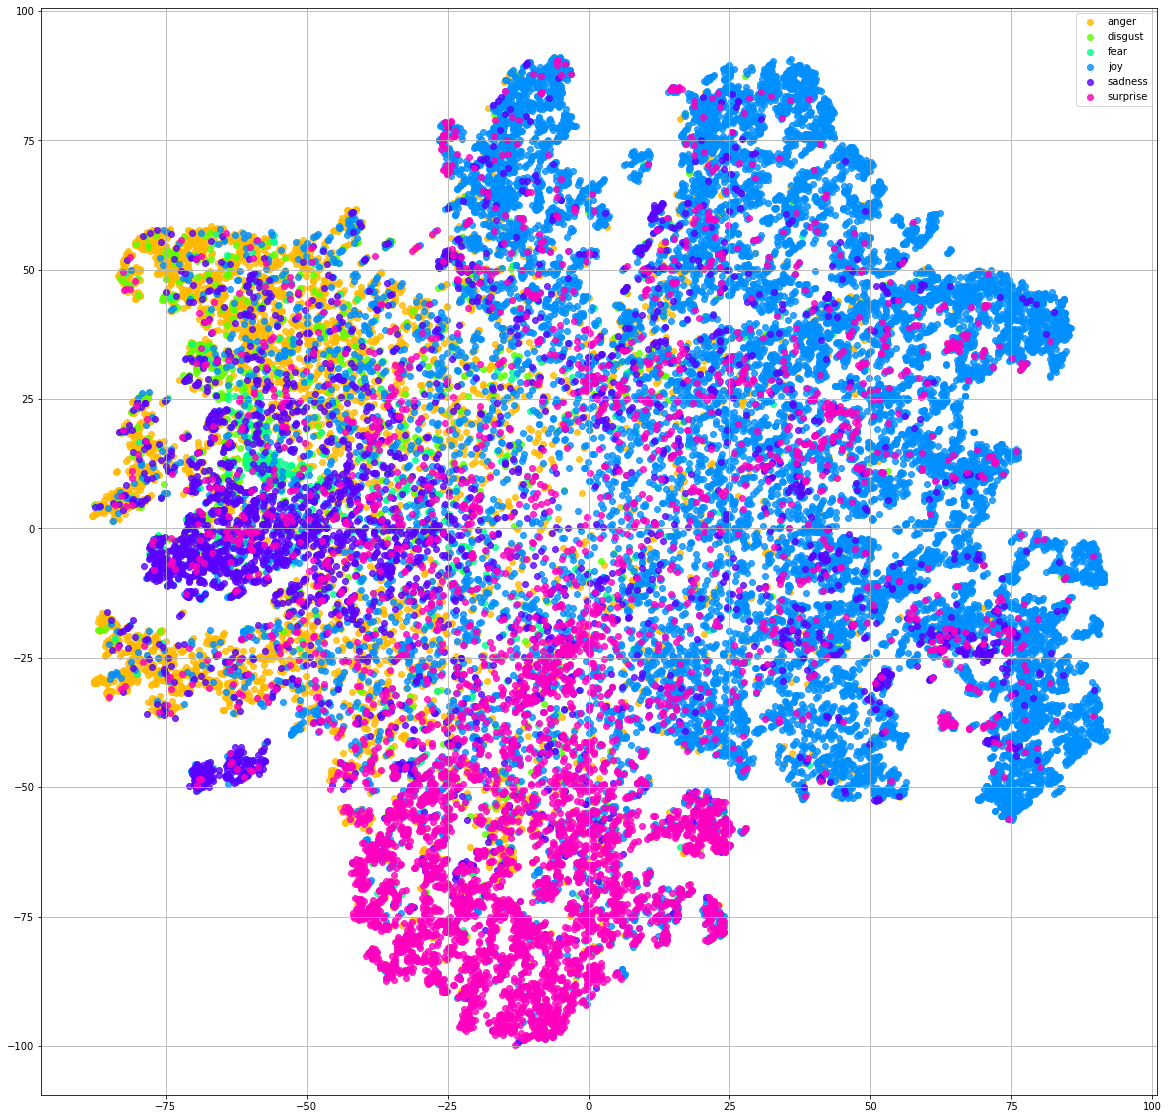

In [24]:
y_true_train_ekman = convert_to_ekman(reverse_one_hot(y_true_train))
y_true_train_ekman = label_multi_one_hot(y_true_train_ekman).numpy()
ekman_fname='data/ekman_mapping.json'
with open(ekman_fname) as f:
    ekman_mapping = json.load(f)
ekman_label_mapping = {}
for idx, key in enumerate(ekman_mapping):
    ekman_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_train[:,:-1]), y_true_train_ekman[:,:-1], ekman_label_mapping, figsize=(20,20))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

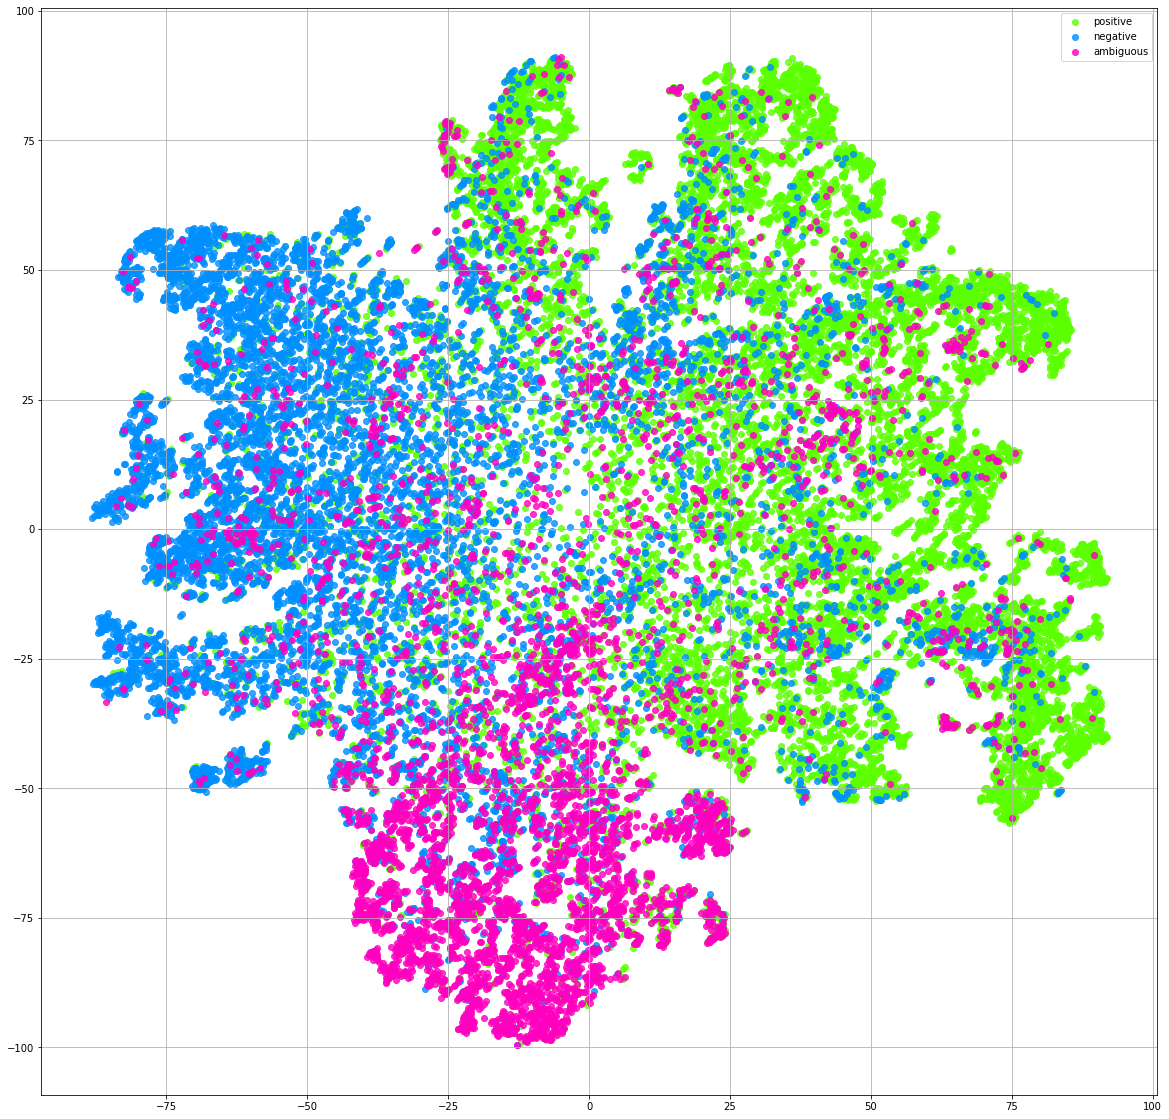

In [32]:
#%%
y_true_train_sentiment = convert_to_sentiment(reverse_one_hot(y_true_train))
y_true_train_sentiment = label_multi_one_hot(y_true_train_sentiment).numpy()
sentiment_fname='data/sentiment_mapping.json'
with open(sentiment_fname) as f:
    sentiment_mapping = json.load(f)
sentiment_label_mapping = {}
for idx, key in enumerate(sentiment_mapping):
    sentiment_label_mapping[idx] = key
visualize_scatter(gen_tsne_values(y_pred_train[:,:-1]), y_true_train_sentiment[:,:-1], sentiment_label_mapping, figsize=(20,20))

In [ ]:
y_pred = (y_pred_test>=0.2) * np.ones(y_pred_test.shape)
test_confusion_matrix = mlb_confusion_matrix(label_mapping, y_true_test, y_pred)

y_pred = (y_pred_train>=0.2) * np.ones(y_pred_train.shape)
train_confusion_matrix = mlb_confusion_matrix(label_mapping, y_true_train, y_pred)

